(landsat2)=
# Landast part 2: rasterio

This notebook reads in the red, and near-ir bands from a landsat 8 image
and calculates the [ndvi](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), defined as

$$ndvi = (nir - red)/(nir + red)$$

where nir and red are the
respective spectral directional reflectances.

To get the landsat data, you'll need to first run {ref}`landsat1`

In [1]:
import pprint
from pathlib import Path

import numpy as np
import rasterio
from matplotlib import pyplot as plt
from pathlib import Path
import a301_lib

******************************
context imported. Front of path:
/home/phil/work



## Get the vancouver image

In [2]:
landsat_dir = Path() / "landsat_scenes"
b4_file = list(landsat_dir.glob("**/*B4.TIF"))[0]
b5_file = list(landsat_dir.glob("**/*B5.TIF"))[0]
mtl_file = list(landsat_dir.glob("**/*MTL.txt"))[0]
print(b4_file,b5_file,mtl_file)

landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_B4.TIF landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_B5.TIF landsat_scenes/LC08_L1TP_047026_20150614_20180131_01_T1/LC08_L1TP_047026_20150614_20180131_01_T1_MTL.txt


* Read in the bands  4 (red) and 5 (near infrared)

Note that rasterio is a pretty complicated object with a lot of functionality.

The full documentation is at https://rasterio.readthedocs.io/en/latest/

In [3]:
with rasterio.open(b4_file) as b4_raster:
    b4_data = b4_raster.read(1)
with rasterio.open(b5_file) as b5_raster:
    b5_data = b5_raster.read(1)
print(b4_data.shape,b5_data.shape)
print(b4_data[:1000,:1000])

(7961, 7851) (7961, 7851)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


* Find the toa reflectance for each channel

Use [toa_reflectance_8](https://github.com/phaustin/a301_2020/blob/c2070ca26090dc4a7e612c1e9c4ed2d9e865ae5e/a301/landsat/toa_reflectance.py#L19) to turn band counts into reflectance.

In [4]:
from sat_lib.landsat.toa_reflectance import toa_reflectance_8, landsat_metadata
meta=landsat_metadata(mtl_file)
out = toa_reflectance_8([4, 5], mtl_file)
print(meta)

in sat_lib init
Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43
Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43


* Silence annoying warnings from numpy

In [5]:
np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

*  NIR is much more reflective than red

In [6]:
out[5]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

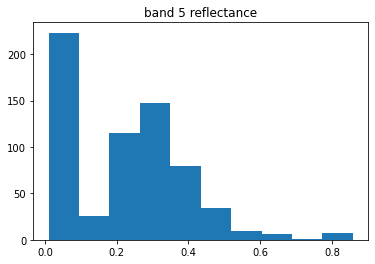

In [7]:
flat_5 = out[5].ravel()
subset = np.random.randint(0, high=len(flat_5), size=1000, dtype='l')
hit = (flat_5[subset] < 1.2) & (flat_5[subset] > 0)
plt.hist(flat_5[subset][hit])
plt.title("band 5 reflectance");

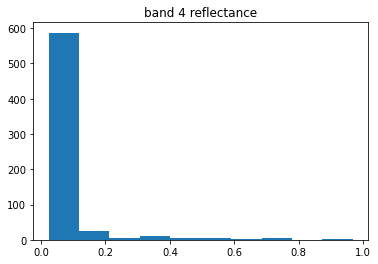

In [8]:
flat_4 = out[4].ravel()
hit = (flat_4[subset] < 1.2) & (flat_4[subset] > 0)
plt.hist(flat_4[subset][hit])
plt.title("band 4 reflectance");

*  Calculate the ndvi

In [9]:
ndvi = (out[5] - out[4]) / (out[5] + out[4])
ndvi_flat = ndvi.ravel()

Text(0.5, 1.0, 'ndvi')

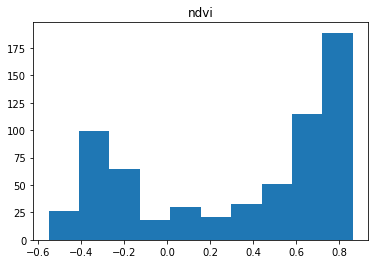

In [10]:
hit = (ndvi_flat[subset] < 1.0) & (ndvi_flat[subset] > -1)
plt.hist(ndvi_flat[subset][hit])
plt.title("ndvi")

* Does the reflectance step matter?

Check to see if you histograms look different when you do the ndvi with raw counts
instead of reflectance.